# Blog Post: Newton's Method for Logistic Regression

In [129]:
%load_ext autoreload
%autoreload 2
from LogisticRegression import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
from matplotlib import pyplot as plt 
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
# generates data for classification problem

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points, p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    return X, y

X, y = classification_data(noise = 0.5)
w = torch.linspace(-1, 1, X.shape[1])

In [131]:
# plots data and boundary decision based on w
# only works for dimension = 2

def plot_data_and_boundary(X, y, w, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the data
    targets = [0, 1]
    markers = ["o", ","]
    colors = ["red", "blue"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = colors[i], cmap = "BrBG", marker = markers[i])

    # Draw the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_values = torch.linspace(x_min, x_max, 100)
    y_values = -(w[0]*x_values + w[2])/w[1]
    ax.plot(x_values, y_values, color='black')

    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    plt.show()

In [132]:
# calculates the accuracy of a model

def accuracy(y_pred, y_true):
    correct = (y_pred == y_true).sum()
    total = y_true.shape[0]
    print(correct)
    return correct / total

In [133]:
LR = LogisticRegression(w)
opt = NewtonOptimizer(LR, w)

losses = []

for _ in range(15000):
    losses.append(LR.loss(X, y))
    opt.step(X, y, alpha = 0.9)

Text(0, 0.5, 'Loss')

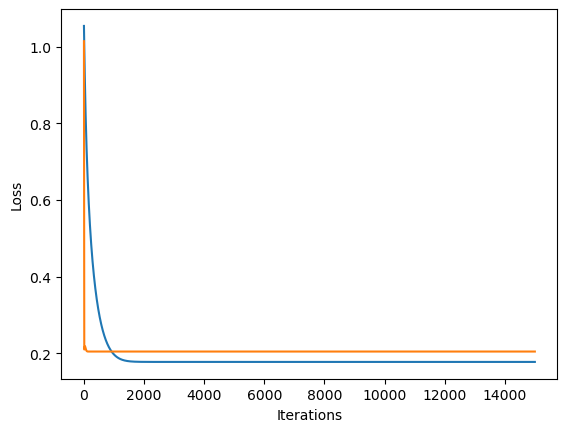

In [134]:
X, y = classification_data(noise = 0.5)
w = torch.linspace(-1, 1, X.shape[1])
w_prev = torch.linspace(-1, 1, X.shape[1])

LR_grad = LogisticRegression(w)
opt = GradientDescentOptimizer(LR_grad, w, w_prev)

losses_grad = []

for _ in range(15000):
    losses_grad.append(LR_grad.loss(X, y))
    opt.step(X, y, alpha = 0.7, beta = 0.9)

plt.plot(losses)
plt.plot(losses_grad)
plt.xlabel("Iterations")
plt.ylabel("Loss")

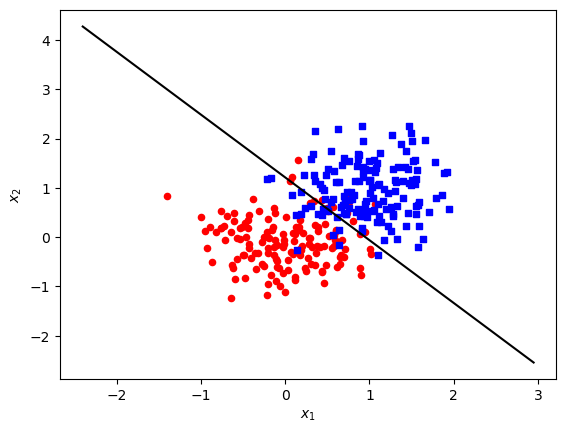

tensor([ 4.3242,  3.3953, -4.1165])
tensor(268)
Accuracy: 0.8933333158493042


In [135]:
plot_data_and_boundary(X, y, LR.w)
print(LR.w)

# Predict the labels
y_pred = LR.predict(X)

# Calculate the accuracy
acc = accuracy(y_pred, y)
print(f'Accuracy: {acc}')

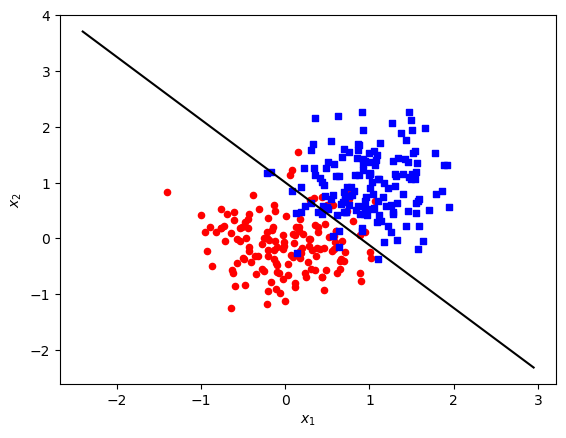

tensor([ 4.0870,  3.6338, -3.6471])
tensor(270)
Accuracy: 0.8999999761581421


In [136]:
plot_data_and_boundary(X, y, LR_grad.w)
print(LR_grad.w)

# Predict the labels
y_pred = LR_grad.predict(X)

# Calculate the accuracy
acc = accuracy(y_pred, y)
print(f'Accuracy: {acc}')

In [137]:
print(LR_grad.loss(X, y))
print(LR.loss(X, y))

w_save = LR_grad.w
LR_grad.w = LR.w

print(LR_grad.loss(X, y))
LR.w = w_save

print(LR.loss(X, y))

tensor(0.2045)
tensor(0.2113)
tensor(0.2113)
tensor(0.2045)


In [138]:
w = torch.tensor([1.0, 1.0, 1.0])
w_prev = torch.tensor([1.0, 1.0, 1.0])

LR_n_test = LogisticRegression(w)
opt = GradientDescentOptimizer(LR_grad, w, w_prev)

LR_g_test = LogisticRegression(w)
opt = NewtonOptimizer(LR, w)

print(LR_n_test.loss(X, y))
print(LR_g_test.loss(X, y))


tensor(0.6889)
tensor(0.6889)
